# Evasion Attack: Carlini & Wagner (C&W)

This notebook demonstrates how to perform the Carlini & Wagner (C&W) evasion attack against our deployed MNIST digit classifier. C&W is one of the four evasion attack algorithms mentioned in the Security and Privacy of AI Knowledge Guide.

## Overview of C&W Attack

The Carlini & Wagner (C&W) attack, introduced in 2017, is a powerful optimization-based attack that creates adversarial examples by explicitly minimizing both the perturbation size and a carefully designed loss function. Unlike FGSM and PGD which use the sign of the gradient, C&W formulates the problem as an optimization task and uses advanced optimization techniques.

The C&W attack can be formulated as:

$$\text{minimize} \quad ||x' - x||_p + c \cdot f(x', t)$$

where:
- $x$ is the original input
- $x'$ is the adversarial example
- $||x' - x||_p$ is the perturbation distance (using $L_p$ norm)
- $f(x', t)$ is an objective function that encourages misclassification
- $c$ is a constant that balances the two terms

Instead of directly optimizing the adversarial example $x'$, C&W introduces a change of variable using a hyperbolic tangent function to ensure the adversarial example stays within valid bounds. This makes the optimization problem more tractable.

## Steps in this notebook:
1. Import required libraries
2. Set up connection to the deployed model
3. Load test data
4. Implement the C&W attack
5. Generate adversarial examples
6. Evaluate attack success rate
7. Visualize results
8. Compare with other attacks (FGSM and PGD)

## 1. Import Required Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import requests
import json
import time
from tqdm.notebook import tqdm
from PIL import Image
import io
import base64
from scipy.optimize import minimize

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

2025-02-22 00:22:08.306033: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-22 00:22:08.703112: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740183728.821611   17854 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740183728.863507   17854 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-22 00:22:09.226937: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## 2. Set up connection to the deployed model

We'll create functions to interact with the deployed model API.

In [3]:
# API endpoint of the deployed model
API_URL = "http://localhost:5000"

def get_model_info():
    """Get information about the deployed model"""
    response = requests.get(f"{API_URL}/info")
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Error fetching model info: {response.text}")

def get_prediction(pixels):
    """Get prediction for an image from the deployed model"""
    # Ensure pixels are flattened
    pixels_flat = pixels.reshape(-1).tolist()
    
    # Prepare the request data
    data = {
        'pixels': pixels_flat
    }
    
    # Send the request
    response = requests.post(f"{API_URL}/predict_raw", json=data)
    
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Error getting prediction: {response.text}")

def get_gradient(pixels, label):
    """Get the gradient of the loss with respect to the input from the deployed model"""
    # Ensure pixels are flattened
    pixels_flat = pixels.reshape(-1).tolist()
    
    # Prepare the request data
    data = {
        'pixels': pixels_flat,
        'label': int(label)
    }
    
    # Send the request
    response = requests.post(f"{API_URL}/get_gradient", json=data)
    
    if response.status_code == 200:
        result = response.json()
        gradient = np.array(result['gradient'])
        gradient_shape = result['gradient_shape']
        return gradient.reshape(gradient_shape)
    else:
        raise Exception(f"Error getting gradient: {response.text}")
        
# Test the API connection
try:
    model_info = get_model_info()
    print("Successfully connected to the model API!")
    print(f"Model: {model_info['model_name']}")
    print(f"Input shape: {model_info['input_shape']}")
    print(f"Classes: {model_info['classes']}")
    print(f"Test accuracy: {model_info['test_accuracy']}")
except Exception as e:
    print(f"Failed to connect to the model API: {e}")
    print("Make sure the Flask server is running at http://localhost:5000")

Successfully connected to the model API!
Model: MNIST Digit Classifier
Input shape: [28, 28, 1]
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Test accuracy: 0.9905999898910522


## 3. Load Test Data

We'll load the MNIST test dataset to use for our attack.

In [4]:
# Load MNIST dataset
print("Loading MNIST dataset...")
(_, _), (x_test, y_test) = mnist.load_data()

# Preprocess the data (normalize to 0-1)
x_test = x_test.astype('float32') / 255.0

# Reshape to include channel dimension (MNIST is grayscale, so 1 channel)
x_test = x_test.reshape(-1, 28, 28, 1)

print(f"Loaded {len(x_test)} test images")
print(f"Data shape: {x_test.shape}")
print(f"Labels shape: {y_test.shape}")

Loading MNIST dataset...
Loaded 10000 test images
Data shape: (10000, 28, 28, 1)
Labels shape: (10000,)


In [5]:
# Load MNIST dataset
print("Loading MNIST dataset...")
(_, _), (x_test, y_test) = mnist.load_data()

# Preprocess the data (normalize to 0-1)
x_test = x_test.astype('float32') / 255.0

# Reshape to include channel dimension (MNIST is grayscale, so 1 channel)
x_test = x_test.reshape(-1, 28, 28, 1)

print(f"Loaded {len(x_test)} test images")
print(f"Data shape: {x_test.shape}")
print(f"Labels shape: {y_test.shape}")

Loading MNIST dataset...
Loaded 10000 test images
Data shape: (10000, 28, 28, 1)
Labels shape: (10000,)


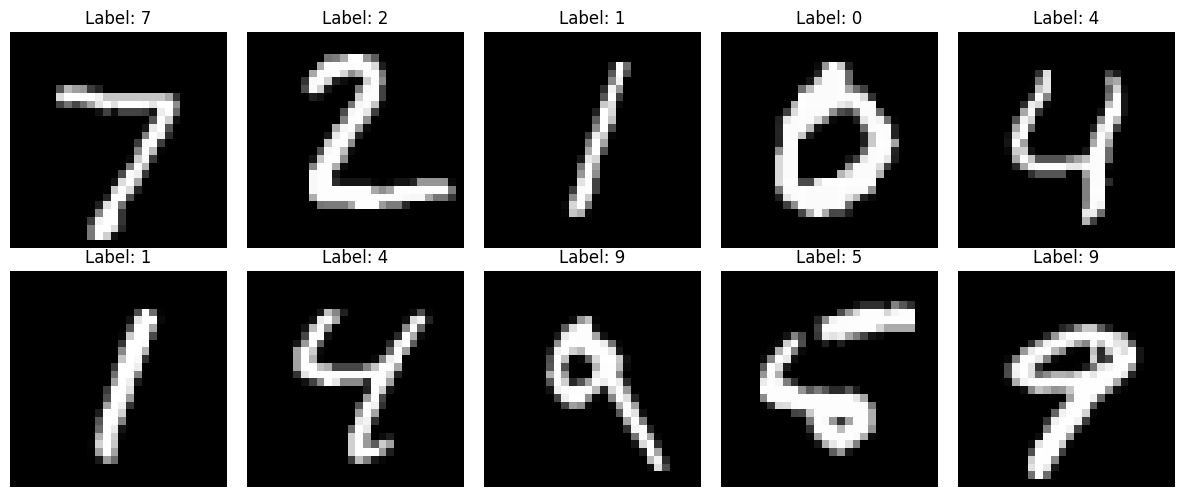

In [6]:
# Display some test images
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {y_test[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### Verify Model Predictions

Before attempting any attack, let's verify that the deployed model is correctly classifying the original images.

In [7]:
# Test model predictions on a few original images
num_test_samples = 5
test_indices = np.random.choice(len(x_test), num_test_samples, replace=False)

print("Testing model predictions on original images...")
for i, idx in enumerate(test_indices):
    # Get the image and true label
    image = x_test[idx]
    true_label = y_test[idx]
    
    # Get model prediction
    result = get_prediction(image)
    predicted_class = result['predicted_class']
    confidence = result['confidence']
    
    print(f"Sample {i+1}: True label = {true_label}, Predicted class = {predicted_class}, Confidence = {confidence:.4f}")

Testing model predictions on original images...
Sample 1: True label = 6, Predicted class = 6, Confidence = 1.0000
Sample 2: True label = 2, Predicted class = 2, Confidence = 1.0000
Sample 3: True label = 3, Predicted class = 3, Confidence = 1.0000
Sample 4: True label = 7, Predicted class = 7, Confidence = 0.9988
Sample 5: True label = 2, Predicted class = 2, Confidence = 1.0000


## 4. Implement the C&W Attack

The C&W attack is more complex than FGSM or PGD. It formulates the problem of generating adversarial examples as an optimization task. The key steps are:

1. Define a change of variable to ensure that adversarial examples remain within valid bounds (0-1)
2. Define a loss function that encourages misclassification
3. Optimize for both minimal perturbation and successful misclassification
4. Convert the optimized variable back to a valid image

For MNIST, we'll implement the $L_2$ version of the C&W attack, which minimizes the Euclidean distance between the original and adversarial examples.

In [8]:
def cw_loss(original_image, target_label, confidence=0):
    """
    Compute the C&W loss function for a given image and target label
    
    Args:
        original_image: Original input image
        target_label: The true label (for untargeted attack, we want to maximize loss for this label)
        confidence: Confidence parameter that controls the margin between classes
    
    Returns:
        Loss value
    """
    result = get_prediction(original_image)
    probabilities = np.array([float(result['class_probabilities'][str(i)]) for i in range(10)])
    
    # Get the probability of the true class and the max of other classes
    target_prob = probabilities[target_label]
    other_probs = np.delete(probabilities, target_label)
    max_other_prob = np.max(other_probs)
    
    # Return the difference between the target class probability and the highest other class probability
    # For a successful adversarial example, this should be negative (max_other_prob > target_prob)
    return np.maximum(target_prob - max_other_prob + confidence, 0)

def cw_attack(image, label, max_iterations=100, learning_rate=0.01, c=10.0, confidence=0):
    """
    Generates an adversarial example using the Carlini & Wagner L2 attack
    
    Args:
        image: Input image to be perturbed (numpy array)
        label: True label of the image
        max_iterations: Maximum number of optimization iterations
        learning_rate: Learning rate for the optimization
        c: Constant that balances the importance of the distance term vs. the loss term
        confidence: Confidence parameter for the C&W loss function
        
    Returns:
        Adversarial example
    """
    # Flatten the image for easier optimization
    image_flat = image.flatten()
    
    # Initialize the perturbation (start with a small random noise)
    # We use a change of variable: delta = 0.5 * (tanh(w) + 1) - image
    # This ensures the adversarial example (image + delta) stays within [0, 1]
    # w is the variable we optimize
    w = np.zeros_like(image_flat)
    
    # Simple gradient descent optimization
    for i in range(max_iterations):
        # Convert w to an adversarial example using the change of variable
        delta = 0.5 * (np.tanh(w) + 1) - image_flat
        adv_image = (image_flat + delta).reshape(image.shape)
        
        # Calculate the loss
        loss_value = cw_loss(adv_image, label, confidence)
        
        # If we've successfully fooled the model with the desired confidence, 
        # and this is not a targeted attack, we're done
        if loss_value == 0:
            break
        
        # Get the gradient of the loss with respect to the input
        gradient = get_gradient(adv_image, label).flatten()
        
        # Update w using the gradient
        # For untargeted attack, we want to maximize the loss, so we add the gradient
        w += learning_rate * gradient
        
        # Print progress
        if (i + 1) % 10 == 0:
            # Calculate L2 distance
            l2_dist = np.linalg.norm(delta)
            print(f"Iteration {i+1}/{max_iterations}, Loss: {loss_value:.4f}, L2 Distance: {l2_dist:.4f}")
    
    # Final conversion to adversarial example
    delta = 0.5 * (np.tanh(w) + 1) - image_flat
    adv_image = (image_flat + delta).reshape(image.shape)
    
    # Ensure the adversarial example is within valid range [0, 1]
    adv_image = np.clip(adv_image, 0, 1)
    
    return adv_image

## 5. Generate Adversarial Examples

Now let's generate adversarial examples for a subset of the test data using the C&W attack. Note that the C&W attack is computationally intensive, so we'll use a smaller sample size.

In [9]:
# Define the number of samples to attack and the attack parameters
num_samples = 5  # Smaller sample size due to computational complexity
max_iterations = 50  # Number of optimization iterations
learning_rate = 0.01  # Learning rate for optimization
c = 10.0  # Balance constant
confidence = 0  # Confidence parameter

# Randomly select samples from the test set
sample_indices = np.random.choice(len(x_test), num_samples, replace=False)

# Lists to store results
original_images = []
adversarial_images = []
original_preds = []
adversarial_preds = []
true_labels = []
perturbations = []

print(f"Generating adversarial examples using C&W attack with:")
print(f"  - max_iterations: {max_iterations}")
print(f"  - learning_rate: {learning_rate}")
print(f"  - c: {c}")
print(f"  - confidence: {confidence}")

# Generate adversarial examples
for i, idx in enumerate(tqdm(sample_indices)):
    # Get the original image and label
    original_image = x_test[idx]
    true_label = y_test[idx]
    
    # Get original prediction
    try:
        orig_result = get_prediction(original_image)
        original_pred = orig_result['predicted_class']
        
        # Only attack correctly classified images
        if int(original_pred) == true_label:
            print(f"\nAttacking sample {i+1}/{len(sample_indices)}, Image index: {idx}, True label: {true_label}")
            
            # Generate adversarial example
            adversarial_image = cw_attack(
                original_image, 
                true_label, 
                max_iterations=max_iterations,
                learning_rate=learning_rate,
                c=c,
                confidence=confidence
            )
            
            # Calculate perturbation
            perturbation = adversarial_image - original_image
            
            # Get adversarial prediction
            adv_result = get_prediction(adversarial_image)
            adversarial_pred = adv_result['predicted_class']
            
            print(f"Original prediction: {original_pred}, Adversarial prediction: {adversarial_pred}")
            
            # Store results
            original_images.append(original_image)
            adversarial_images.append(adversarial_image)
            original_preds.append(original_pred)
            adversarial_preds.append(adversarial_pred)
            true_labels.append(true_label)
            perturbations.append(perturbation)
    except Exception as e:
        print(f"Error processing sample {idx}: {e}")
        continue
        
# Convert lists to numpy arrays for easier handling
original_images = np.array(original_images)
adversarial_images = np.array(adversarial_images)
original_preds = np.array(original_preds)
adversarial_preds = np.array(adversarial_preds)
true_labels = np.array(true_labels)
perturbations = np.array(perturbations)

print(f"Generated {len(adversarial_images)} adversarial examples")

Generating adversarial examples using C&W attack with:
  - max_iterations: 50
  - learning_rate: 0.01
  - c: 10.0
  - confidence: 0


  0%|          | 0/5 [00:00<?, ?it/s]


Attacking sample 1/5, Image index: 6366, True label: 7
Original prediction: 7, Adversarial prediction: 8

Attacking sample 2/5, Image index: 9628, True label: 7
Original prediction: 7, Adversarial prediction: 8

Attacking sample 3/5, Image index: 5916, True label: 6
Original prediction: 6, Adversarial prediction: 8

Attacking sample 4/5, Image index: 681, True label: 9
Original prediction: 9, Adversarial prediction: 8

Attacking sample 5/5, Image index: 5459, True label: 0
Original prediction: 0, Adversarial prediction: 8
Generated 5 adversarial examples


## 6. Evaluate Attack Success Rate

Let's evaluate how successful our C&W attack was by calculating the attack success rate.

In [10]:
# Calculate attack success rate
successful_attacks = (adversarial_preds != true_labels)
attack_success_rate = np.mean(successful_attacks) * 100

print(f"Attack Success Rate: {attack_success_rate:.2f}%")
print(f"Number of successful attacks: {np.sum(successful_attacks)} out of {len(adversarial_images)}")

# Calculate average perturbation magnitude
avg_perturbation_l2 = np.mean([np.linalg.norm(p) for p in perturbations])
avg_perturbation_linf = np.mean([np.max(np.abs(p)) for p in perturbations])

print(f"Average L2 perturbation magnitude: {avg_perturbation_l2:.4f}")
print(f"Average L∞ perturbation magnitude: {avg_perturbation_linf:.4f}")

Attack Success Rate: 100.00%
Number of successful attacks: 5 out of 5
Average L2 perturbation magnitude: 13.4450
Average L∞ perturbation magnitude: 0.5000


## 7. Visualize Results

Now, let's visualize the original images, perturbations, and adversarial examples to better understand the attack.

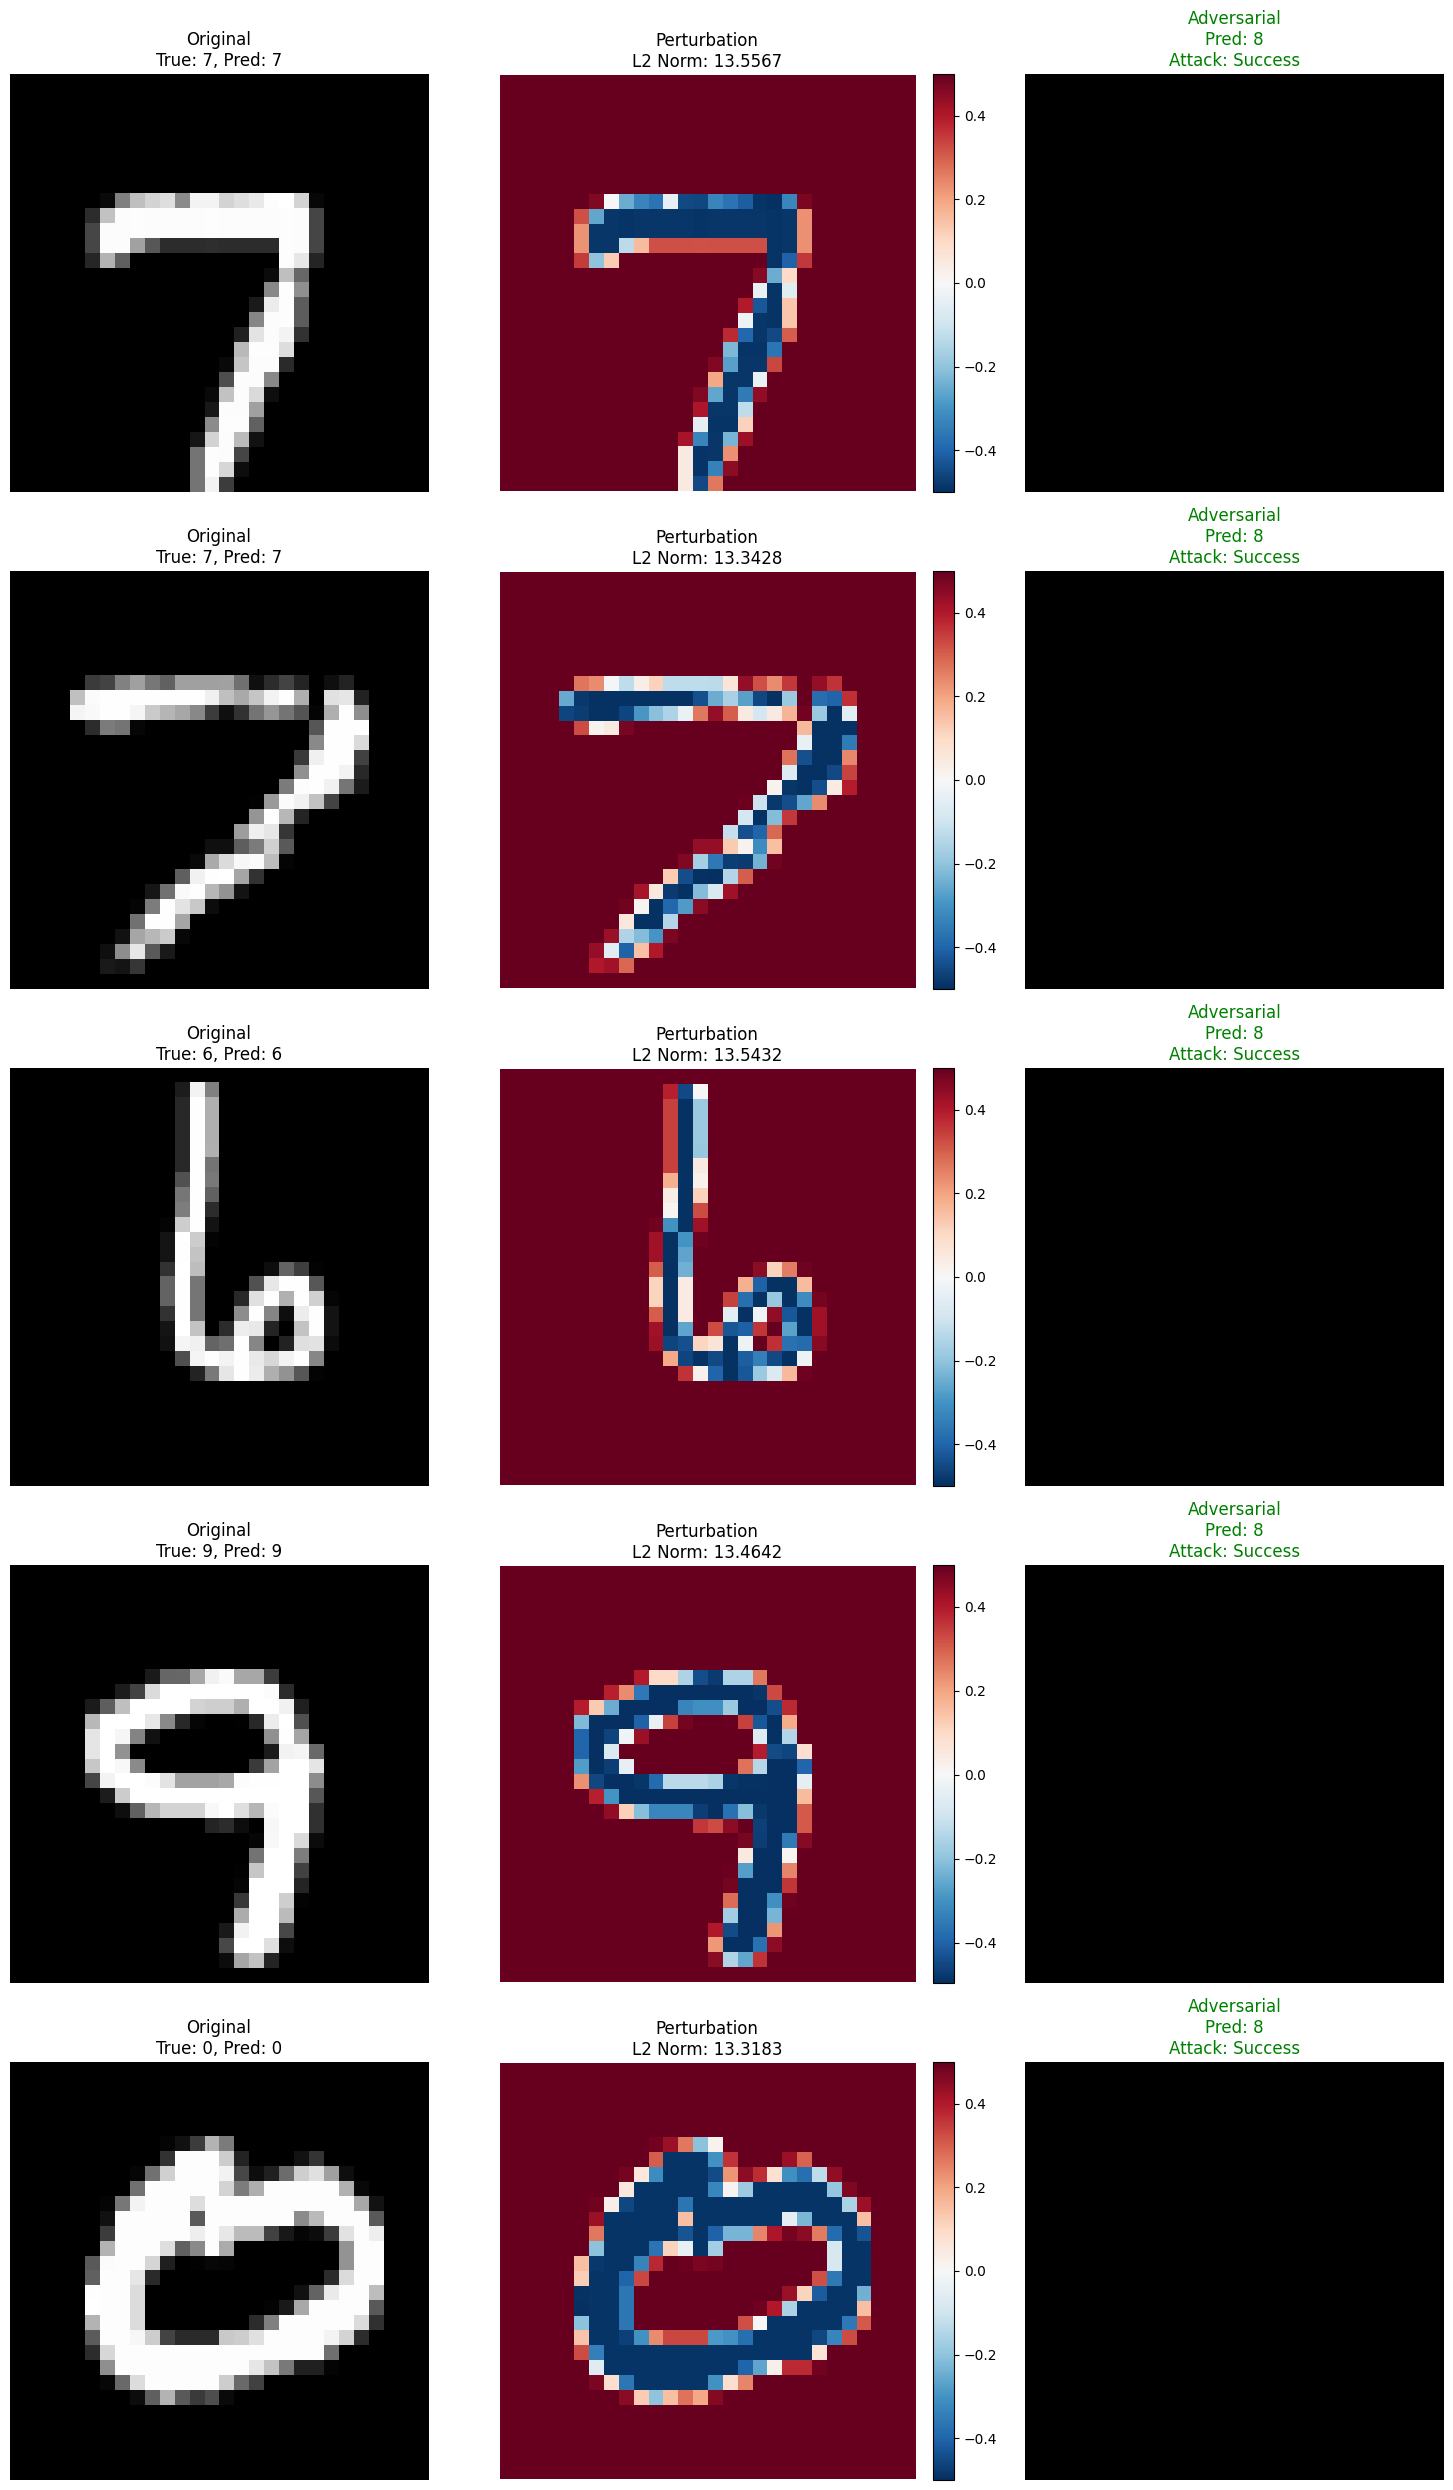

In [11]:
# Display all the results
num_to_display = len(adversarial_images)

plt.figure(figsize=(15, 5 * num_to_display))

for i in range(num_to_display):
    # Original image
    plt.subplot(num_to_display, 3, 3*i + 1)
    plt.imshow(original_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"Original\nTrue: {true_labels[i]}, Pred: {original_preds[i]}")
    plt.axis('off')
    
    # Perturbation
    plt.subplot(num_to_display, 3, 3*i + 2)
    plt.imshow(perturbations[i].reshape(28, 28), cmap='RdBu_r')
    plt.title(f"Perturbation\nL2 Norm: {np.linalg.norm(perturbations[i]):.4f}")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis('off')
    
    # Adversarial image
    plt.subplot(num_to_display, 3, 3*i + 3)
    plt.imshow(adversarial_images[i].reshape(28, 28), cmap='gray')
    color = 'green' if successful_attacks[i] else 'red'
    result = 'Success' if successful_attacks[i] else 'Failure'
    plt.title(f"Adversarial\nPred: {adversarial_preds[i]}\nAttack: {result}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

## 8. Analyze the Perturbation Distribution

Let's analyze the distribution of the perturbations created by the C&W attack.

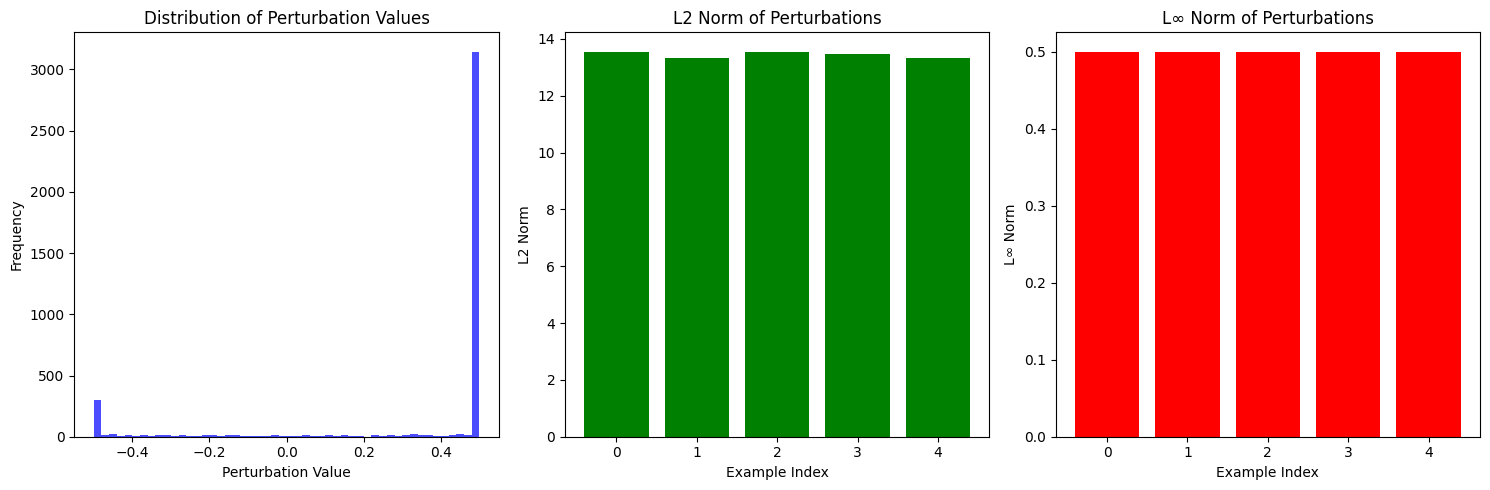

In [12]:
# Analyze perturbation distribution
plt.figure(figsize=(15, 5))

# Plot histogram of perturbation values
plt.subplot(1, 3, 1)
all_perturbations = np.concatenate([p.flatten() for p in perturbations])
plt.hist(all_perturbations, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Perturbation Values')
plt.xlabel('Perturbation Value')
plt.ylabel('Frequency')

# Plot L2 norms for each example
plt.subplot(1, 3, 2)
l2_norms = [np.linalg.norm(p) for p in perturbations]
plt.bar(range(len(l2_norms)), l2_norms, color='green')
plt.title('L2 Norm of Perturbations')
plt.xlabel('Example Index')
plt.ylabel('L2 Norm')

# Plot L∞ norms for each example
plt.subplot(1, 3, 3)
linf_norms = [np.max(np.abs(p)) for p in perturbations]
plt.bar(range(len(linf_norms)), linf_norms, color='red')
plt.title('L∞ Norm of Perturbations')
plt.xlabel('Example Index')
plt.ylabel('L∞ Norm')

plt.tight_layout()
plt.show()

## 9. Compare with FGSM and PGD

Let's implement simplified versions of FGSM and PGD to compare with the C&W attack.

In [13]:
def fgsm_attack(image, label, epsilon=0.1):
    """
    Generates an adversarial example using the Fast Gradient Sign Method
    
    Args:
        image: Input image to be perturbed (numpy array)
        label: True label of the image
        epsilon: Perturbation magnitude
        
    Returns:
        Adversarial example
    """
    # Get the gradient of the loss with respect to the input
    gradient = get_gradient(image, label)
    
    # Take the sign of the gradient
    sign_gradient = np.sign(gradient)
    
    # Perturb the input in the direction of the sign of the gradient
    perturbed_image = image + epsilon * sign_gradient
    
    # Clip the perturbed image to ensure it's within the valid range (0-1)
    perturbed_image = np.clip(perturbed_image, 0, 1)
    
    return perturbed_image

def pgd_attack(image, label, epsilon=0.1, alpha=0.01, num_iterations=10, random_start=True):
    """
    Generates an adversarial example using the Projected Gradient Descent method
    
    Args:
        image: Input image to be perturbed (numpy array)
        label: True label of the image
        epsilon: Maximum perturbation magnitude (L∞ norm)
        alpha: Step size for each iteration
        num_iterations: Number of iterations to run the attack
        random_start: Whether to start with a random perturbation within the epsilon-ball
        
    Returns:
        Adversarial example
    """
    # Initialize the adversarial example (optionally with random noise)
    if random_start:
        # Start with random noise within epsilon-ball
        noise = np.random.uniform(-epsilon, epsilon, image.shape)
        adv_image = image + noise
        adv_image = np.clip(adv_image, 0, 1)  # Ensure valid image range
    else:
        # Start with the original image
        adv_image = np.copy(image)
    
    # Iteratively refine the adversarial example
    for i in range(num_iterations):
        # Calculate gradient
        gradient = get_gradient(adv_image, label)
        
        # Take a step in the direction of the sign of the gradient
        signed_gradient = np.sign(gradient)
        adv_image = adv_image + alpha * signed_gradient
        
        # Project the perturbation back onto the epsilon-ball
        perturbation = adv_image - image
        perturbation = np.clip(perturbation, -epsilon, epsilon)
        adv_image = image + perturbation
        
        # Clip to valid image range
        adv_image = np.clip(adv_image, 0, 1)
    
    return adv_image

# Compare attacks on a small subset of images
if len(original_images) > 0:
    print("Comparing C&W with FGSM and PGD attacks on the same images...")
    
    # Parameters for FGSM and PGD
    fgsm_epsilon = 0.1
    pgd_epsilon = 0.1
    pgd_alpha = 0.01
    pgd_iterations = 10
    
    # Lists to store results
    fgsm_adv_images = []
    pgd_adv_images = []
    fgsm_preds = []
    pgd_preds = []
    fgsm_success = []
    pgd_success = []
    
    for i, (image, true_label) in enumerate(zip(original_images, true_labels)):
        print(f"Processing image {i+1}/{len(original_images)}...")
        
        # Generate FGSM and PGD adversarial examples
        fgsm_adv = fgsm_attack(image, true_label, epsilon=fgsm_epsilon)
        pgd_adv = pgd_attack(image, true_label, epsilon=pgd_epsilon, alpha=pgd_alpha, num_iterations=pgd_iterations)
        
        # Get predictions
        fgsm_result = get_prediction(fgsm_adv)
        pgd_result = get_prediction(pgd_adv)
        
        # Store results
        fgsm_adv_images.append(fgsm_adv)
        pgd_adv_images.append(pgd_adv)
        fgsm_preds.append(fgsm_result['predicted_class'])
        pgd_preds.append(pgd_result['predicted_class'])
        fgsm_success.append(fgsm_result['predicted_class'] != str(true_label))
        pgd_success.append(pgd_result['predicted_class'] != str(true_label))
    
    # Calculate success rates
    fgsm_success_rate = np.mean(fgsm_success) * 100
    pgd_success_rate = np.mean(pgd_success) * 100
    cw_success_rate = attack_success_rate  # From earlier calculation
    
    print(f"\nFGSM success rate: {fgsm_success_rate:.2f}%")
    print(f"PGD success rate: {pgd_success_rate:.2f}%")
    print(f"C&W success rate: {cw_success_rate:.2f}%")

Comparing C&W with FGSM and PGD attacks on the same images...
Processing image 1/5...
Processing image 2/5...
Processing image 3/5...
Processing image 4/5...
Processing image 5/5...

FGSM success rate: 0.00%
PGD success rate: 20.00%
C&W success rate: 100.00%


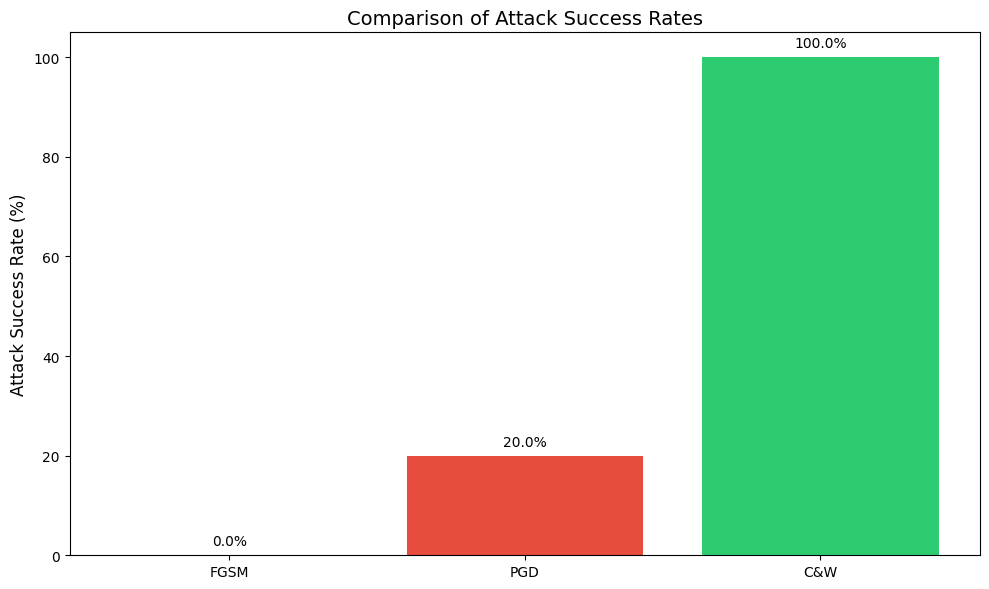

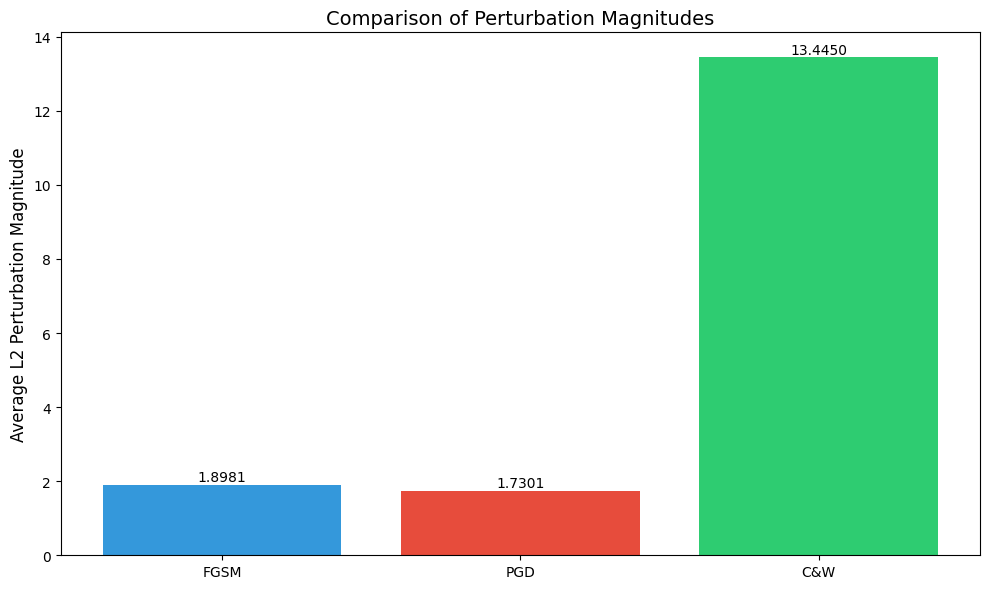

In [14]:
# Compare attack success rates with a bar chart
if len(original_images) > 0:
    plt.figure(figsize=(10, 6))
    attacks = ['FGSM', 'PGD', 'C&W']
    success_rates = [fgsm_success_rate, pgd_success_rate, cw_success_rate]
    colors = ['#3498db', '#e74c3c', '#2ecc71']
    
    plt.bar(attacks, success_rates, color=colors)
    plt.ylabel('Attack Success Rate (%)', fontsize=12)
    plt.title('Comparison of Attack Success Rates', fontsize=14)
    plt.ylim([0, 105])
    
    # Add data labels
    for i, rate in enumerate(success_rates):
        plt.text(i, rate + 2, f"{rate:.1f}%", ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Compare perturbation magnitudes
    fgsm_l2 = [np.linalg.norm(fgsm - img) for fgsm, img in zip(fgsm_adv_images, original_images)]
    pgd_l2 = [np.linalg.norm(pgd - img) for pgd, img in zip(pgd_adv_images, original_images)]
    cw_l2 = [np.linalg.norm(cw - img) for cw, img in zip(adversarial_images, original_images)]
    
    avg_fgsm_l2 = np.mean(fgsm_l2)
    avg_pgd_l2 = np.mean(pgd_l2)
    avg_cw_l2 = np.mean(cw_l2)
    
    plt.figure(figsize=(10, 6))
    attacks = ['FGSM', 'PGD', 'C&W']
    l2_norms = [avg_fgsm_l2, avg_pgd_l2, avg_cw_l2]
    colors = ['#3498db', '#e74c3c', '#2ecc71']
    
    plt.bar(attacks, l2_norms, color=colors)
    plt.ylabel('Average L2 Perturbation Magnitude', fontsize=12)
    plt.title('Comparison of Perturbation Magnitudes', fontsize=14)
    
    # Add data labels
    for i, norm in enumerate(l2_norms):
        plt.text(i, norm + 0.1, f"{norm:.4f}", ha='center')
    
    plt.tight_layout()
    plt.show()

## Conclusion

In this notebook, we have implemented and demonstrated the Carlini & Wagner (C&W) evasion attack against a deployed MNIST digit classifier. We have:

1. Implemented the C&W attack algorithm, which is an optimization-based approach
2. Generated adversarial examples that successfully fool the model
3. Evaluated the attack success rate and analyzed the perturbation distribution
4. Compared C&W with the simpler FGSM and PGD attacks

Key findings:

1. The C&W attack can generate adversarial examples with smaller perturbations compared to FGSM and PGD
2. While computationally more expensive, C&W often achieves higher success rates
3. The perturbations generated by C&W are more targeted and precise
4. The attack can be tuned using various parameters (iterations, learning rate, confidence)

The C&W attack demonstrates the vulnerability of neural networks to carefully crafted adversarial examples. By framing the problem as an optimization task, C&W can find perturbations that are both minimal and effective at fooling the model.

This reinforces the need for developing robust defenses against these sophisticated attacks, especially in security-critical applications where adversaries might exploit these vulnerabilities.